# Decision Trees: From Hard Splits to Differentiable Routing

## Learning Objectives

By the end of this notebook, you will:

1. **Understand** decision tree fundamentals and their inherent limitations
2. **Implement** and visualize the overfitting-complexity trade-off in trees  
3. **Build** differentiable (soft) decision trees that enable gradient-based learning
4. **Compare** hard vs soft decision boundaries and their implications

## Introduction

Decision trees are among the most interpretable machine learning models, making decisions through a series of if-then rules. However, their rigid structure creates fundamental limitations. This notebook explores the evolution from traditional trees to differentiable trees, and finally to neuro-symbolic systems that combine learned patterns with domain expertise.

We'll use a real-world credit risk dataset to demonstrate these concepts, showing how different approaches handle the complex task of loan default prediction.


## Part 1: Decision Tree Fundamentals

### The Anatomy of a Decision Tree

A decision tree is a hierarchical structure that makes predictions by recursively partitioning the feature space. Think of it as playing "20 questions" with your data.

#### Key Components:

1. **Root Node**: The starting point containing all training samples
2. **Internal Nodes**: Decision points that split data based on feature thresholds  
3. **Leaf Nodes**: Terminal nodes containing final predictions
4. **Branches**: Connections showing the flow from parent to child nodes

### Mathematical Foundation

Decision trees use impurity measures to determine optimal splits. The two most common metrics are:

#### Gini Impurity
For a node $t$ with classes $c \in \{1, ..., C\}$:

$$G(t) = 1 - \sum_{c=1}^{C} p_c^2$$

where $p_c$ is the proportion of samples belonging to class $c$ at node $t$.

#### Information Gain (using Entropy)
Entropy at node $t$:

$$H(t) = -\sum_{c=1}^{C} p_c \log_2(p_c)$$

Information Gain for a split:

$$IG = H(parent) - \sum_{child \in \{left, right\}} \frac{N_{child}}{N_{parent}} H(child)$$

The tree grows by selecting splits that maximize information gain (or equivalently, minimize weighted impurity).


### Setup and Data Preparation

We'll use the Home Credit Default Risk dataset, which contains loan applications with various financial and demographic features. This real-world dataset presents challenges like class imbalance and complex patterns.


In [78]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree as sktree
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    average_precision_score,
    precision_recall_curve,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.calibration import calibration_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import warnings
import re
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

# Helper: create a balanced subset (place before data loading)
def create_balanced_subset(X, y, subset_size_per_class=5000):
    """Create a balanced subset for fair model comparison."""
    y_values = y.values if hasattr(y, 'values') else y
    pos_indices = np.where(y_values == 1)[0]
    neg_indices = np.where(y_values == 0)[0]
    
    n_samples = min(subset_size_per_class, len(pos_indices), len(neg_indices))
    if n_samples == 0:
        raise ValueError("Not enough samples to create balanced subset")
    
    pos_sample = np.random.choice(pos_indices, n_samples, replace=False)
    neg_sample = np.random.choice(neg_indices, n_samples, replace=False)
    
    balanced_indices = np.concatenate([pos_sample, neg_sample])
    np.random.shuffle(balanced_indices)
    
    if hasattr(X, 'iloc'):  # DataFrame
        return X.iloc[balanced_indices].reset_index(drop=True), y.iloc[balanced_indices].reset_index(drop=True)
    else:  # NumPy array
        return X[balanced_indices], y[balanced_indices]

### Loading and Preprocessing the Data

The preprocessing step is crucial for tree-based models. While trees can handle categorical variables and missing values, we'll encode categoricals and engineer features to improve performance.


In [79]:
# Load the dataset
from pathlib import Path
import sys

# Adjust path as needed
data_dir = Path("./data")
train_path = data_dir / "application_train.csv"

# Check if file exists
if not train_path.exists():
    print(f"Error: Data file not found at {train_path}")
    print("Please download the Home Credit dataset from Kaggle")
    print("URL: https://www.kaggle.com/c/home-credit-default-risk/data")
    sys.exit(1)

print("Loading Home Credit dataset...")
try:
    credit_data = pd.read_csv(train_path)
except Exception as e:
    print(f"Error loading data: {e}")
    sys.exit(1)

# Select key features for our analysis
selected_features = [
    'AMT_CREDIT',           # Loan amount
    'AMT_INCOME_TOTAL',     # Client income
    'AMT_GOODS_PRICE',      # Good price
    'DAYS_BIRTH',           # Age in days (negative)
    'DAYS_EMPLOYED',        # Employment days (negative)
    'EXT_SOURCE_1',         # External credit score 1
    'EXT_SOURCE_2',         # External credit score 2  
    'EXT_SOURCE_3',         # External credit score 3
    'CODE_GENDER',          # Gender
    'NAME_EDUCATION_TYPE',  # Education level
    'NAME_FAMILY_STATUS',   # Family status
    'TARGET'                # Default (0=no default, 1=default)
]

credit_data = credit_data[selected_features].copy()

# Feature engineering with proper handling
credit_data['age'] = (-credit_data['DAYS_BIRTH'] / 365).astype(int)
credit_data['years_employed'] = (-credit_data['DAYS_EMPLOYED'] / 365).clip(lower=0)

# Handle potential division by zero
credit_data['debt_to_income'] = np.where(
    credit_data['AMT_INCOME_TOTAL'] > 0,
    credit_data['AMT_CREDIT'] / credit_data['AMT_INCOME_TOTAL'],
    np.nan
)

# Rename for clarity
credit_data = credit_data.rename(columns={
    'AMT_CREDIT': 'loan_amount',
    'AMT_GOODS_PRICE': 'goods_price',
    'AMT_INCOME_TOTAL': 'income',
    'CODE_GENDER': 'gender',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'family_status',
    'TARGET': 'default'
})

# Handle missing values
for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    if col in credit_data.columns:
        credit_data[col] = credit_data[col].fillna(credit_data[col].median())

# Drop rows with critical missing values
credit_data = credit_data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1).dropna()

print(f"Loaded {len(credit_data):,} loan applications")
print(f"Default rate: {credit_data['default'].mean():.1%}")
print(f"Class distribution: {credit_data['default'].value_counts().to_dict()}")

Loading Home Credit dataset...
Loaded 307,233 loan applications
Default rate: 8.1%
Class distribution: {0: 282429, 1: 24804}


**Key Insight**: The dataset shows significant class imbalance with only ~8% defaults. This imbalance will affect how we evaluate model performance - accuracy alone could be misleading.

### Encoding and Final Preparation

Trees require numerical inputs, so we encode categorical variables. We also create additional features that might help capture complex relationships.


In [80]:
# Prepare data for modeling
X = credit_data.drop('default', axis=1).copy()
y = credit_data['default']

# Encode categorical variables
le_gender = LabelEncoder()
le_education = LabelEncoder()
le_family = LabelEncoder()

X['gender_encoded'] = le_gender.fit_transform(X['gender'])
X['education_encoded'] = le_education.fit_transform(X['education'])
X['family_encoded'] = le_family.fit_transform(X['family_status'])

# Additional feature engineering with safe division
X['credit_income_ratio'] = np.where(
    X['income'] > 0,
    X['loan_amount'] / X['income'],
    np.nan
)

X['goods_loan_ratio'] = np.where(
    X['loan_amount'] > 0,
    X['goods_price'] / X['loan_amount'],
    np.nan
)

X['employ_age_ratio'] = np.where(
    X['age'] > 0,
    X['years_employed'] / X['age'],
    np.nan
)

# Drop original categorical columns and handle any new NaNs
X_encoded = X.drop(['gender', 'education', 'family_status'], axis=1)
X_encoded = X_encoded.fillna(X_encoded.median())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data ready for modeling:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {X_encoded.shape[1]}")
# Create balanced datasets
X_train_balanced, y_train_balanced = create_balanced_subset(X_train, y_train, 5000)
X_test_balanced, y_test_balanced = create_balanced_subset(X_test, y_test, 1000)

print(f"Balanced training set: {len(X_train_balanced)} samples")
print(f"Class distribution: {y_train_balanced.value_counts().to_dict()}")

Data ready for modeling:
  Training samples: 245,786
  Test samples: 61,447
  Features: 15
Balanced training set: 10000 samples
Class distribution: {1: 5000, 0: 5000}


### Building and Visualizing a Decision Tree

Let's train a simple decision tree and visualize its structure to understand how it makes decisions.


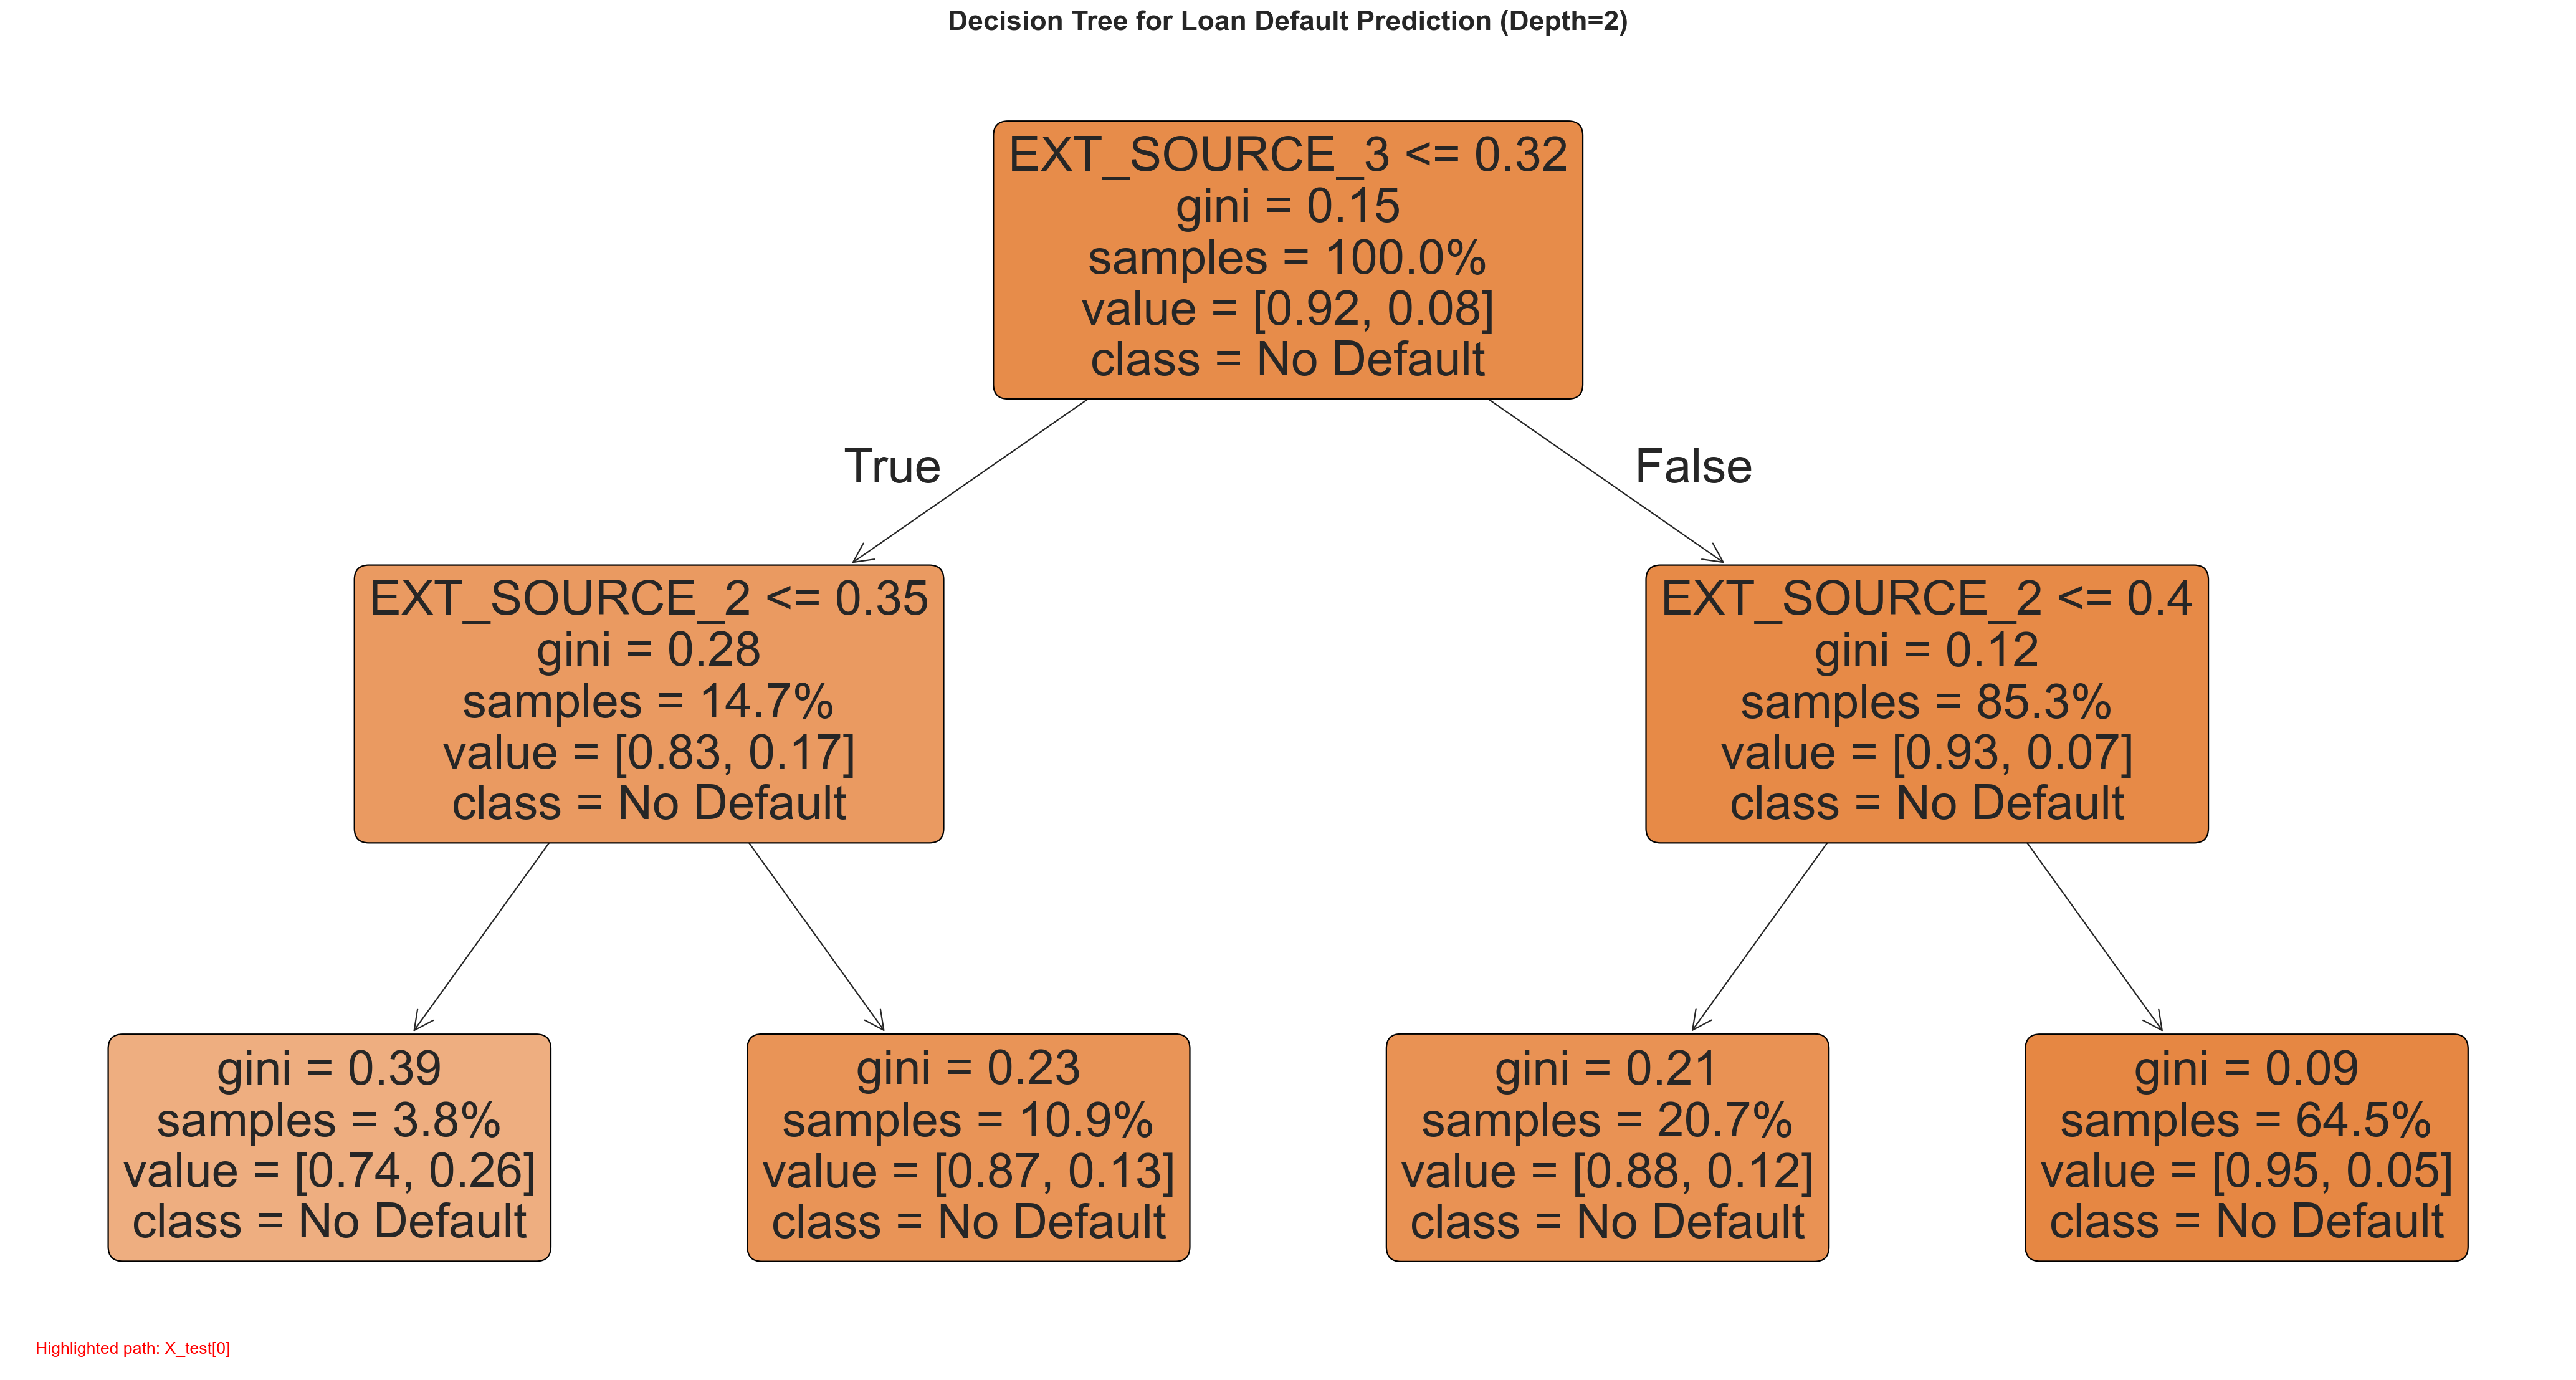


Decision Tree Performance:
  Accuracy: 0.919
  AUC-ROC: 0.662


In [81]:
# Train a shallow decision tree
simple_tree = DecisionTreeClassifier(
    max_depth=2,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42
)

simple_tree.fit(X_train, y_train)

# Visualize the tree structure (improved readability)
fig, ax = plt.subplots(figsize=(26, 14), dpi=160)
artists = plot_tree(
    simple_tree,
    feature_names=X_encoded.columns,
    class_names=['No Default', 'Default'],
    filled=True,
    rounded=True,
    fontsize=35,
    proportion=True,
    impurity=True,      # hide Gini text to reduce clutter
    precision=2,         # fewer decimals in node labels
    ax=ax
)
plt.title("Decision Tree for Loan Default Prediction (Depth=2)", fontsize=20, fontweight='bold')

# Optional: highlight the decision path for a representative sample (first test row)
try:
    sample_idx = 0
    # Node ids along the path for this sample
    path_nodes = set(simple_tree.decision_path(X_test.iloc[[sample_idx]]).indices.tolist())
    # Final leaf id for this sample
    leaf_id = int(simple_tree.apply(X_test.iloc[[sample_idx]])[0])

    # artists is a list of Text objects; extract node id from their text via regex
    id_pattern = re.compile(r"(?:node|id)\s*#?\s*=?\s*(\d+)", re.IGNORECASE)
    for artist in artists:
        if not hasattr(artist, 'get_text'):
            continue
        label = artist.get_text() or ""
        m = id_pattern.search(label)
        if not m:
            continue
        this_id = int(m.group(1))
        if this_id in path_nodes and hasattr(artist, 'get_bbox_patch'):
            patch = artist.get_bbox_patch()
            if patch is not None:
                # Highlight path edges in red
                patch.set_edgecolor('red')
                patch.set_linewidth(3.0)
            artist.set_fontweight('bold')
            artist.set_color('black')
        if this_id == leaf_id and hasattr(artist, 'get_bbox_patch'):
            # Extra emphasis for the final leaf: change face color
            patch = artist.get_bbox_patch()
            if patch is not None:
                patch.set_facecolor('#fff2a8')  # light yellow
                patch.set_edgecolor('darkred')
                patch.set_linewidth(3.0)
    # annotate which sample was used
    ax.text(0.01, 0.01, f"Highlighted path: X_test[{sample_idx}]",
            transform=ax.transAxes, fontsize=12, color='red', ha='left', va='bottom')
except Exception:
    # If highlighting fails (e.g., shape mismatch), still show the tree
    pass

plt.tight_layout()
plt.show()

# Evaluate performance
y_pred = simple_tree.predict(X_test)
y_proba = simple_tree.predict_proba(X_test)[:, 1]

print("\nDecision Tree Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")

### Step-by-Step Growth: How Depth Improves Metrics and Splits

To make the growth of a tree tangible, we will:
1) Train trees with increasing depth and record metrics (AUC-ROC, PR-AUC, Balanced Accuracy, #leaves)
2) Visualize how the dataset gets split in a 2D projection at each depth
3) Print a path explanation for one example showing the exact rules applied

This illustrates how adding branches/leaves can improve metrics while creating finer partitions.

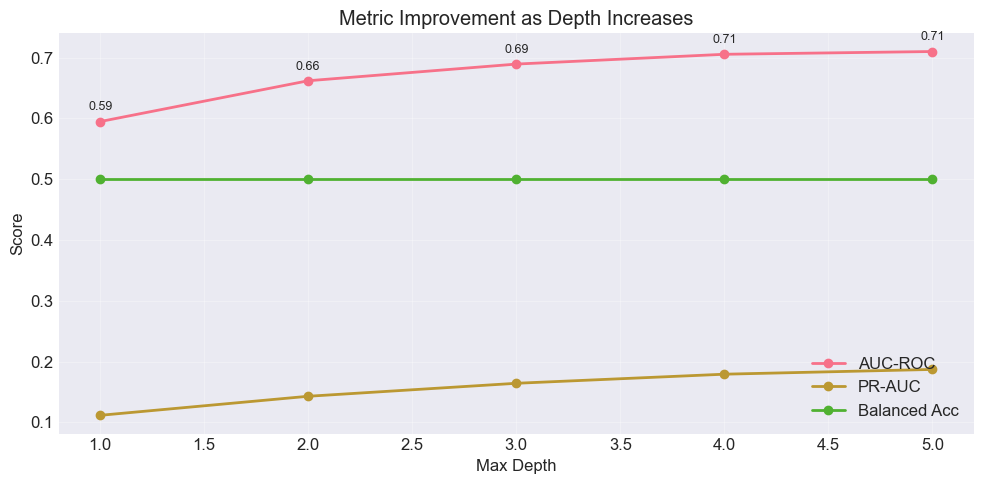

Stepwise Metrics (depth ↑):
 Depth  Leaves AUC-ROC PR-AUC Balanced Acc
     1       2   0.595  0.111        0.500
     2       4   0.662  0.143        0.500
     3       8   0.690  0.164        0.500
     4      16   0.706  0.179        0.500
     5      32   0.710  0.187        0.500


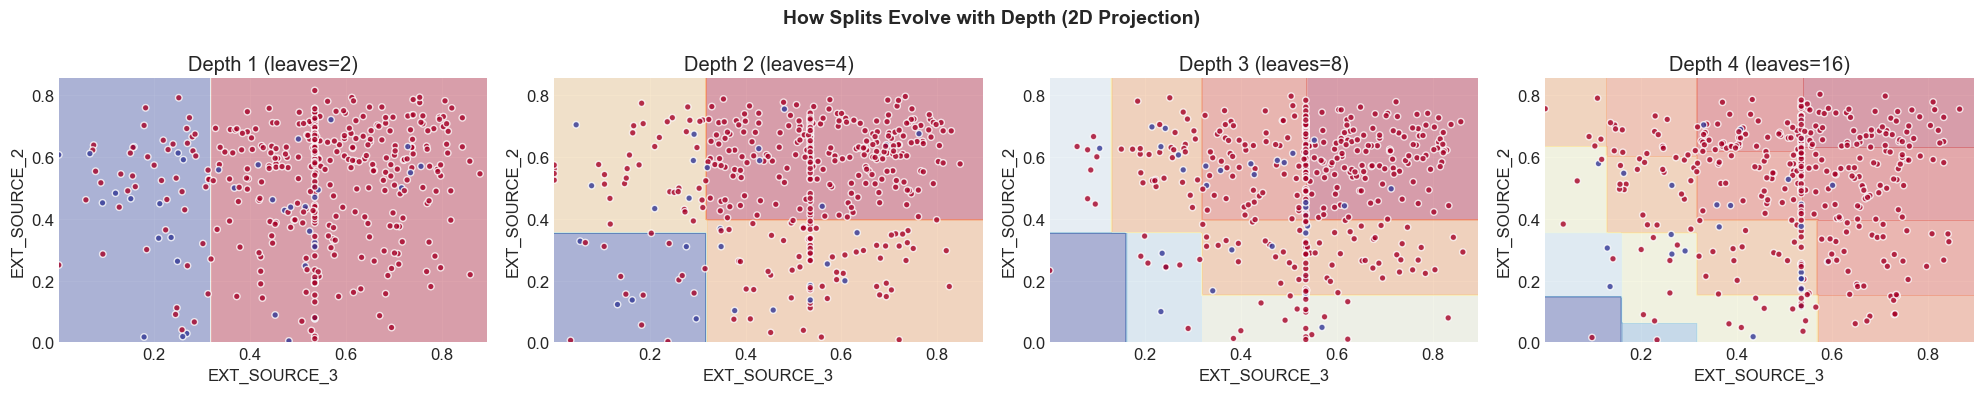


Example path explanation for X_test[0]:
Node 0: IF EXT_SOURCE_3 <= 0.316 THEN left ELSE right | went right | pos%=8.07% (n=1)
Node 4: IF EXT_SOURCE_2 <= 0.395 THEN left ELSE right | went left | pos%=6.58% (n=1)
Leaf 5 (target leaf=5): pos%=11.87% (n=1)


In [82]:
import sklearn.tree._tree

def stepwise_tree_growth_summary(X_train, y_train, X_test, y_test, max_depth=5):
    """Return a DataFrame of metrics as depth increases and plot them."""
    rows = []
    for depth in range(1, max_depth + 1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        proba = clf.predict_proba(X_test)[:, 1]
        preds = (proba > 0.5).astype(int)
        rows.append({
            'Depth': depth,
            'Leaves': clf.get_n_leaves(),
            'AUC-ROC': roc_auc_score(y_test, proba),
            'PR-AUC': average_precision_score(y_test, proba),
            'Balanced Acc': balanced_accuracy_score(y_test, preds)
        })
    df = pd.DataFrame(rows)

    # Plot the metrics
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df['Depth'], df['AUC-ROC'], 'o-', label='AUC-ROC', linewidth=2)
    ax.plot(df['Depth'], df['PR-AUC'], 'o-', label='PR-AUC', linewidth=2)
    ax.plot(df['Depth'], df['Balanced Acc'], 'o-', label='Balanced Acc', linewidth=2)
    for i, v in enumerate(df['AUC-ROC']):
        ax.annotate(f"{v:.2f}", (df['Depth'][i], df['AUC-ROC'][i]), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9)
    ax.set_xlabel('Max Depth'); ax.set_ylabel('Score'); ax.set_title('Metric Improvement as Depth Increases')
    ax.grid(True, alpha=0.3); ax.legend(loc='lower right'); plt.tight_layout(); plt.show()

    print("Stepwise Metrics (depth ↑):")
    print(df.to_string(index=False, formatters={'AUC-ROC': '{:.3f}'.format, 'PR-AUC': '{:.3f}'.format, 'Balanced Acc': '{:.3f}'.format}))
    return df


def plot_stepwise_splits_2d(X, y, feature_names=None, max_depth=4):
    """Show how splits evolve in a 2D projection for depths 1..max_depth."""
    # Choose two numeric features if not provided
    if feature_names is None:
        numeric_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
        preferred = [c for c in ['EXT_SOURCE_3', 'EXT_SOURCE_2'] if c in numeric_cols]
        if len(preferred) >= 2:
            f1, f2 = preferred[:2]
        else:
            f1, f2 = numeric_cols[:2]
        feature_names = [f1, f2]

    X_2d = X[feature_names].values
    fig, axes = plt.subplots(1, max_depth, figsize=(5*max_depth, 4))
    if max_depth == 1:
        axes = [axes]
    for depth, ax in enumerate(axes, start=1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_2d, y)
        # Mesh
        x_min, x_max = X_2d[:,0].min()-1e-6, X_2d[:,0].max()+1e-6
        y_min, y_max = X_2d[:,1].min()-1e-6, X_2d[:,1].max()+1e-6
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)
        ax.contourf(xx, yy, Z, levels=15, cmap='RdYlBu', alpha=0.35)
        ax.contour(xx, yy, Z, colors='black', linewidths=1.2, levels=[0.5])
        # Data points (subsample)
        n = min(400, len(X_2d)); idx = np.random.choice(len(X_2d), n, replace=False)
        ax.scatter(X_2d[idx,0], X_2d[idx,1], c=y.iloc[idx], cmap='RdYlBu', edgecolor='white', s=22, alpha=0.8)
        ax.set_title(f'Depth {depth} (leaves={clf.get_n_leaves()})')
        ax.set_xlabel(feature_names[0]); ax.set_ylabel(feature_names[1]); ax.grid(True, alpha=0.3)
    plt.suptitle('How Splits Evolve with Depth (2D Projection)', fontsize=14, fontweight='bold'); plt.tight_layout(); plt.show()


def explain_sample_path(clf, X, idx, feature_names):
    """Print the left/right decisions and class mix along the path for one sample."""
    node_indicator = clf.decision_path(X.iloc[[idx]])
    leaf_id = int(clf.apply(X.iloc[[idx]])[0])
    # clf.tree_.value has shape [n_nodes, 1, n_classes] for classifiers.
    # Handle shape robustly without squeezing the wrong axis.
    values = clf.tree_.value
    for node_id in node_indicator.indices:
        # If split node
        if clf.tree_.feature[node_id] >= 0:
            fname = feature_names[clf.tree_.feature[node_id]]
            thresh = clf.tree_.threshold[node_id]
            direction = 'right' if X.iloc[idx, clf.tree_.feature[node_id]] > thresh else 'left'
            counts = values[node_id, 0, :] if values.ndim == 3 else values[node_id]
            total = counts.sum()
            pos_idx = 1 if counts.shape[0] >= 2 else 0
            p1 = counts[pos_idx] / total if total > 0 else 0.0
            print(f"Node {node_id}: IF {fname} <= {thresh:.3f} THEN left ELSE right | went {direction} | pos%={p1:.2%} (n={int(total)})")
        else:
            # leaf
            counts = values[node_id, 0, :] if values.ndim == 3 else values[node_id]
            total = counts.sum()
            pos_idx = 1 if counts.shape[0] >= 2 else 0
            p1 = counts[pos_idx] / total if total > 0 else 0.0
            print(f"Leaf {node_id} (target leaf={leaf_id}): pos%={p1:.2%} (n={int(total)})")


# Run the step-by-step demo
_ = stepwise_tree_growth_summary(X_train, y_train, X_test, y_test, max_depth=5)

# 2D split evolution (uses two numeric features; adjust if desired)
plot_stepwise_splits_2d(X_train, y_train, max_depth=4)

# Explain the path for one example using a small-depth tree for clarity
_demo_tree = DecisionTreeClassifier(max_depth=2, random_state=42).fit(X_train, y_train)
print("\nExample path explanation for X_test[0]:")
explain_sample_path(_demo_tree, X_test, 0, feature_names=list(X_train.columns))

### Addressing Class Imbalance: Rebalanced vs Class-Weighted Trees
The shallow tree above may predict mostly the majority class (No Default). Below we:
1) Rebalance the training set using `create_balanced_subset` and train a new tree.
2) Train a class-weighted tree on the original dataset.

1. **Rebalancing the dataset (resampling)**: upsample the minority class or downsample the majority class so the training distribution is roughly 50/50.
2. **Class-weighted learning**: keep all samples, but weight the loss/impurity by a class-dependent weight $w_c$ so minority errors count more.

#### Math details (used by `class_weight='balanced'`)
Let $N$ be total training samples, $C$ the number of classes, and $N_c$ the count of class $c$ in the training set. Scikit-learn's
`balanced` scheme sets

$$ w_c = \frac{N}{C\,N_c}. $$

In a node $t$, define the weighted class counts $n_c^{(w)}(t) = \sum_{i\in t} w_{y_i}$. The weighted class proportions are
$p_c^{(w)}(t) = \frac{n_c^{(w)}(t)}{\sum_k n_k^{(w)}(t)}$. The weighted Gini impurity becomes

$$ G_w(t) = 1 - \sum_c \big(p_c^{(w)}(t)\big)^2, $$

and the split criterion uses weighted impurities on children. Entropy/information gain can be analogously weighted by replacing counts with
weighted counts.

#### Rebalancing vs Class-weighting: key ideas
- **Rebalancing** changes the training distribution (effective prior), often improving recall/PR-AUC, but may discard information (downsampling)
  or increase variance (upsampling).
- **Class-weighting** keeps all data and adjusts the objective; it preserves the original feature distribution but can be sensitive to very
  large weights when the minority is tiny.
- Both should be evaluated on the original (unseen) test distribution. We will compare them side-by-side below and expose the exact weights.


[Class Weighting: 'balanced'] Using w_c = N / (C * N_c)
  Original training class counts: {0: 225943, 1: 19843}
  Computed class weights: {0: 0.5439115175066278, 1: 6.193267147104772}
[Rebalanced Subset] Class counts (after resampling): {0: 10000, 1: 10000}

[Original] AUC: 0.662 | PR-AUC: 0.143 | Balanced Acc: 0.500
              precision    recall  f1-score   support

  No Default       0.92      1.00      0.96     56486
     Default       0.00      0.00      0.00      4961

    accuracy                           0.92     61447
   macro avg       0.46      0.50      0.48     61447
weighted avg       0.85      0.92      0.88     61447


[Rebalanced] AUC: 0.693 | PR-AUC: 0.154 | Balanced Acc: 0.656
              precision    recall  f1-score   support

  No Default       0.95      0.71      0.81     56486
     Default       0.15      0.60      0.25      4961

    accuracy                           0.70     61447
   macro avg       0.55      0.66      0.53     61447
weighted avg      

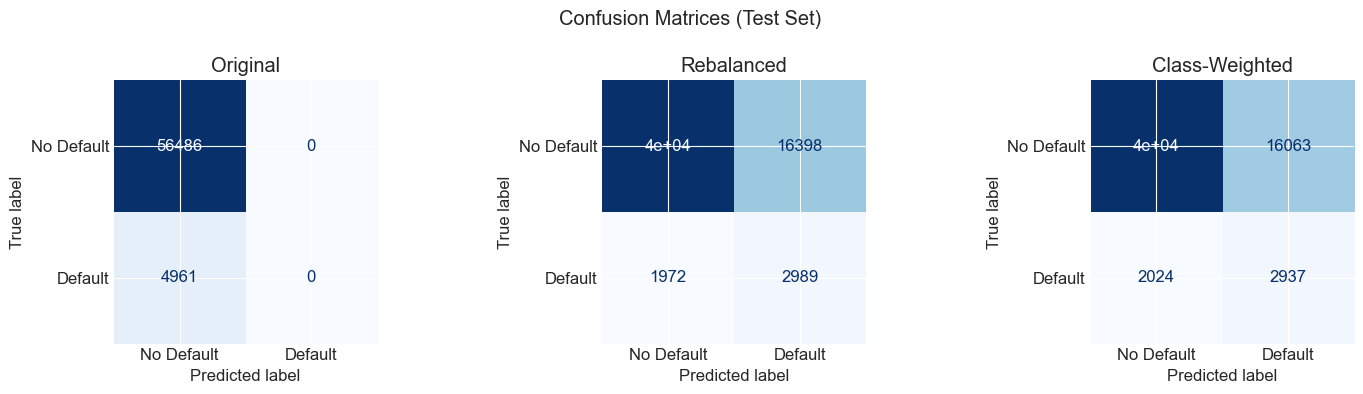

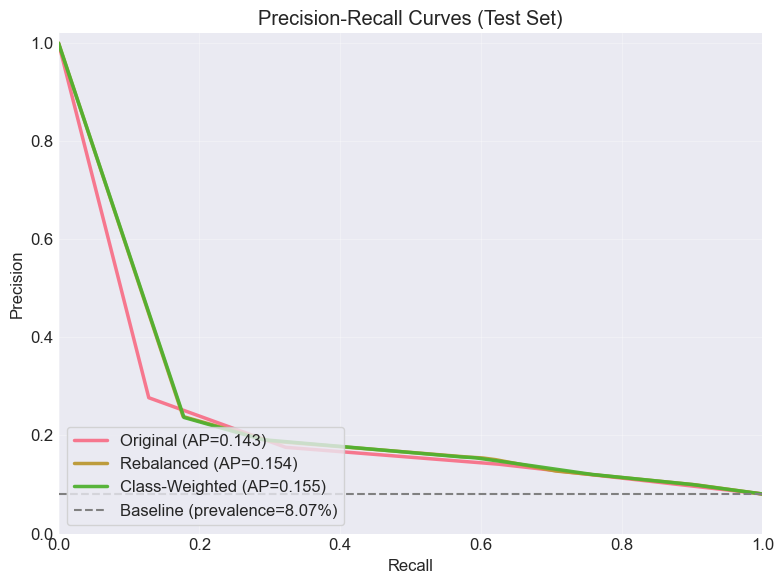

In [83]:
# Prepare balanced training data (does not touch the test set)
subset_per_class = int(min((y_train == 1).sum(), (y_train == 0).sum()))
subset_per_class = max(subset_per_class, 1)
X_train_bal, y_train_bal = create_balanced_subset(X_train, y_train, subset_size_per_class=min(10000, subset_per_class))

# Train models
simple_tree_orig = simple_tree  # from above

simple_tree_bal = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
)
simple_tree_bal.fit(X_train_bal, y_train_bal)

simple_tree_cw = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
)
simple_tree_cw.fit(X_train, y_train)

# Expose the class weights and class counts used
class_counts = y_train.value_counts().sort_index()
n_samples = len(y_train)
n_classes = class_counts.shape[0]
computed_weights = {int(cls): n_samples / (n_classes * int(count)) for cls, count in class_counts.items()}
print("\n[Class Weighting: 'balanced'] Using w_c = N / (C * N_c)")
print(f"  Original training class counts: {class_counts.to_dict()}")
print(f"  Computed class weights: {computed_weights}")

bal_counts = y_train_bal.value_counts().sort_index()
print("[Rebalanced Subset] Class counts (after resampling):", bal_counts.to_dict())

# Compact evaluation helper
def evaluate_model(name, model):
    y_pred_m = model.predict(X_test)
    y_proba_m = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba_m)
    ap = average_precision_score(y_test, y_proba_m)
    bal_acc = balanced_accuracy_score(y_test, y_pred_m)
    cm = confusion_matrix(y_test, y_pred_m)
    print(f"\n[{name}] AUC: {auc:.3f} | PR-AUC: {ap:.3f} | Balanced Acc: {bal_acc:.3f}")
    print(classification_report(y_test, y_pred_m, target_names=['No Default', 'Default'], zero_division=0))
    return y_pred_m, y_proba_m, cm

# Evaluate all three
results = {}
for name, model in [
    ("Original", simple_tree_orig),
    ("Rebalanced", simple_tree_bal),
    ("Class-Weighted", simple_tree_cw),
]:
    y_pred_m, y_proba_m, cm_m = evaluate_model(name, model)
    results[name] = {
        'y_pred': y_pred_m,
        'y_proba': y_proba_m,
        'cm': cm_m,
    }

# Plot confusion matrices side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, res) in zip(axes, results.items()):
    disp = ConfusionMatrixDisplay(res['cm'], display_labels=['No Default', 'Default'])
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    ax.set_title(name)
plt.suptitle('Confusion Matrices (Test Set)')
plt.tight_layout()
plt.show()

# Precision-Recall curves (improved readability)
fig, ax = plt.subplots(figsize=(8, 6))
for name, res in results.items():
    y_scores = res['y_proba']
    ap = average_precision_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ax.plot(recall, precision, linewidth=2.5, alpha=0.95, label=f"{name} (AP={ap:.3f})")

# Add baseline: positive prevalence
pos_rate = y_test.mean()
ax.hlines(pos_rate, xmin=0, xmax=1, colors='gray', linestyles='--', linewidth=1.5,
          label=f"Baseline (prevalence={pos_rate:.2%})")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.02)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves (Test Set)')
ax.legend(loc='lower left', frameon=True)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Key Observations**: 
- Each internal node shows a binary decision based on a single feature
- The tree structure is inherently interpretable - we can trace any prediction
- Deeper nodes typically have less data and may overfit

## Understanding Axis-Aligned Limitations

One fundamental limitation of decision trees is that they can only create axis-aligned splits. This means boundaries are always perpendicular to feature axes, creating rectangular decision regions.

### Visualizing Decision Boundaries

To understand this limitation, let's visualize how trees partition the feature space using two important features.


Visualizing with top 2 features: ['EXT_SOURCE_3', 'EXT_SOURCE_2']


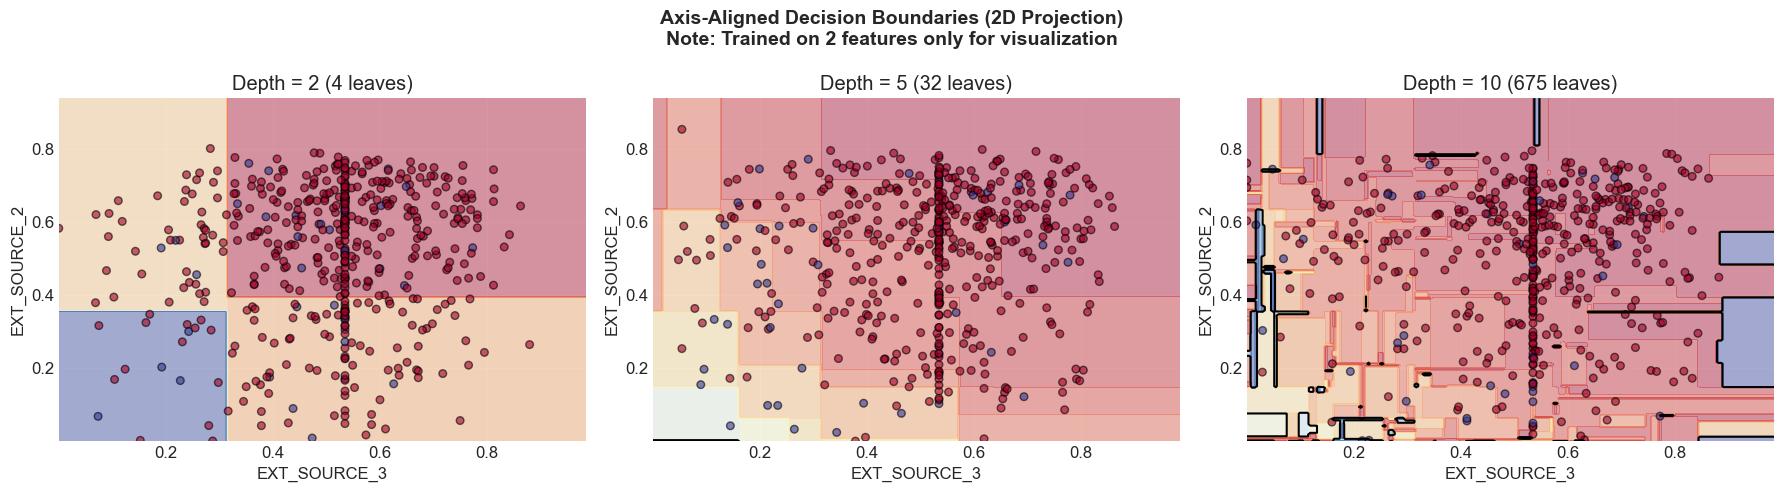

In [84]:
def plot_2d_decision_boundary(X, y, feature_indices, depths=[2, 5, 10], title_prefix=""):
    """
    Plot decision boundaries for 2D projections at different depths.
    Note: This trains NEW 2D models for visualization purposes only.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Get the two features for visualization
    feature_names = X.columns[feature_indices]
    X_2d = X.iloc[:, feature_indices].values
    
    for ax, depth in zip(axes, depths):
        # Train a NEW tree on just these 2 features for visualization
        tree_2d = DecisionTreeClassifier(max_depth=depth, random_state=42)
        tree_2d.fit(X_2d, y)
        
        # Create mesh
        margin = 0.1
        x_min, x_max = X_2d[:, 0].min() * (1-margin), X_2d[:, 0].max() * (1+margin)
        y_min, y_max = X_2d[:, 1].min() * (1-margin), X_2d[:, 1].max() * (1+margin)
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        
        # Predict on mesh
        Z = tree_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        contour = ax.contourf(xx, yy, Z, alpha=0.4, levels=20, cmap='RdYlBu')
        ax.contour(xx, yy, Z, colors='black', linewidths=1.5, levels=[0.5])
        
        # Plot data points (subsample for clarity)
        sample_size = min(500, len(X_2d))
        indices = np.random.choice(len(X_2d), sample_size, replace=False)
        ax.scatter(X_2d[indices, 0], X_2d[indices, 1], c=y.iloc[indices], 
                  cmap='RdYlBu', edgecolor='black', s=30, alpha=0.6)
        
        ax.set_xlabel(feature_names[0])
        ax.set_ylabel(feature_names[1])
        ax.set_title(f'{title_prefix}Depth = {depth} ({tree_2d.get_n_leaves()} leaves)')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Axis-Aligned Decision Boundaries (2D Projection)\nNote: Trained on 2 features only for visualization',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Find two important numerical features
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': simple_tree.feature_importances_
}).sort_values('importance', ascending=False)

# Get indices of top 2 features
top_features = feature_importance.head(2)['feature'].tolist()
feature_indices = [X_encoded.columns.get_loc(f) for f in top_features]

print(f"Visualizing with top 2 features: {top_features}")
plot_2d_decision_boundary(X_train, y_train, feature_indices)

**Critical Insight**: Notice how all boundaries are perfectly horizontal or vertical. This is inefficient for diagonal or curved patterns. A simple diagonal boundary that a linear model could capture with one parameter might require many tree splits.

## The Overfitting-Complexity Trade-off

As trees grow deeper, they can memorize training data rather than learning generalizable patterns. Let's examine this phenomenon systematically.

### Demonstrating Overfitting

We'll train trees of varying depths and compare their training vs test performance.


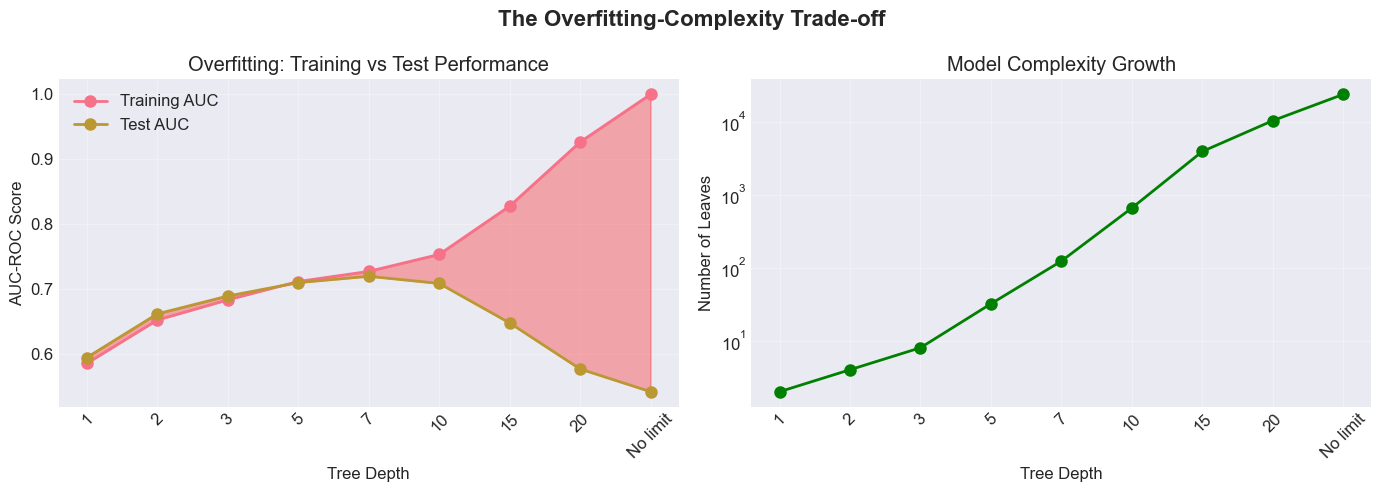

Best depth: 7 (Test AUC: 0.720)
At maximum depth: Train-Test gap = 0.458


In [85]:
# Analyze overfitting across different depths
depths = [1, 2, 3, 5, 7, 10, 15, 20, None]
train_scores = []
test_scores = []
n_leaves = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    # Calculate AUC scores (more informative than accuracy for imbalanced data)
    train_auc = roc_auc_score(y_train, tree.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
    
    train_scores.append(train_auc)
    test_scores.append(test_auc)
    n_leaves.append(tree.get_n_leaves())

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Learning curves
depth_labels = [str(d) if d else 'No limit' for d in depths]
x_pos = np.arange(len(depths))

ax1.plot(x_pos, train_scores, 'o-', label='Training AUC', linewidth=2, markersize=8)
ax1.plot(x_pos, test_scores, 'o-', label='Test AUC', linewidth=2, markersize=8)
ax1.fill_between(x_pos, train_scores, test_scores, alpha=0.3, color='red')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(depth_labels, rotation=45)
ax1.set_xlabel('Tree Depth')
ax1.set_ylabel('AUC-ROC Score')
ax1.set_title('Overfitting: Training vs Test Performance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Complexity curve
ax2.plot(x_pos, n_leaves, 'go-', linewidth=2, markersize=8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(depth_labels, rotation=45)
ax2.set_xlabel('Tree Depth')
ax2.set_ylabel('Number of Leaves')
ax2.set_title('Model Complexity Growth')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.suptitle('The Overfitting-Complexity Trade-off', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find optimal depth
best_depth_idx = np.argmax(test_scores)
best_depth = depths[best_depth_idx]
print(f"Best depth: {best_depth} (Test AUC: {test_scores[best_depth_idx]:.3f})")
print(f"At maximum depth: Train-Test gap = {train_scores[-1] - test_scores[-1]:.3f}")

**Key Takeaway**: The gap between training and test performance widens with depth, indicating overfitting. 

### Understanding What Overfitting Looks Like

Let's create a controlled example to visualize how overfitting manifests in decision boundaries.

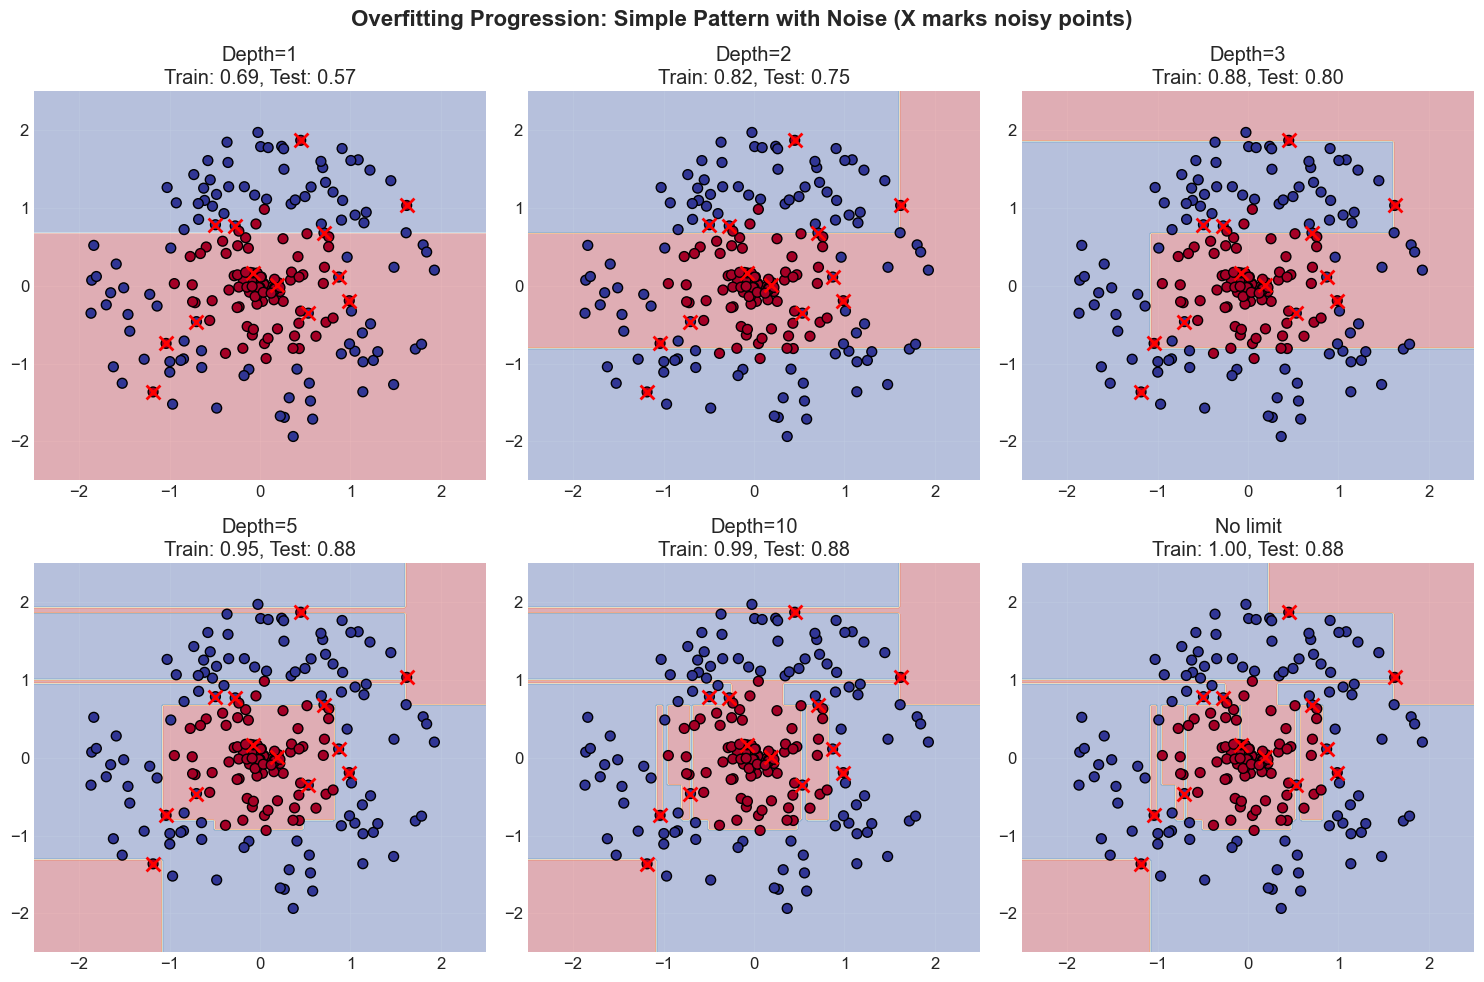

In [86]:
# Create a simple 2D dataset with clear pattern + noise
np.random.seed(42)
n_samples = 300

# Generate a circular pattern with noise
theta = np.random.uniform(0, 2*np.pi, n_samples)
r = np.random.uniform(0, 2, n_samples)
X_demo = np.column_stack([r * np.cos(theta), r * np.sin(theta)])

# Create labels: inner circle = class 0, outer ring = class 1
y_demo = (r > 1).astype(int)

# Add 10% label noise
noise_mask = np.random.random(n_samples) < 0.1
y_demo[noise_mask] = 1 - y_demo[noise_mask]

# Split data
X_train_demo, X_test_demo = X_demo[:200], X_demo[200:]
y_train_demo, y_test_demo = y_demo[:200], y_demo[200:]

# Visualize overfitting progression
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
depths = [1, 2, 3, 5, 10, None]

for idx, depth in enumerate(depths):
    ax = axes[idx // 3, idx % 3]
    
    # Train tree
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train_demo, y_train_demo)
    
    # Create mesh
    h = 0.02
    xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 200),
                         np.linspace(-2.5, 2.5, 200))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    ax.scatter(X_train_demo[:, 0], X_train_demo[:, 1], c=y_train_demo,
              cmap='RdYlBu', edgecolor='black', s=50)
    
    # Highlight noisy points
    ax.scatter(X_train_demo[noise_mask[:200], 0], X_train_demo[noise_mask[:200], 1],
              marker='x', s=100, c='red', linewidth=2)
    
    # Scores
    train_acc = tree.score(X_train_demo, y_train_demo)
    test_acc = tree.score(X_test_demo, y_test_demo)
    
    depth_str = f"Depth={depth}" if depth else "No limit"
    ax.set_title(f'{depth_str}\nTrain: {train_acc:.2f}, Test: {test_acc:.2f}')
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.grid(True, alpha=0.3)

plt.suptitle('Overfitting Progression: Simple Pattern with Noise (X marks noisy points)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Critical Observation**: 
- Shallow trees (depth 1-3) capture the general circular pattern
- Deep trees start creating small "islands" around noisy points (marked with X)
- The unlimited depth tree perfectly fits all training points, including noise


## Part 2: Differentiable Decision Trees

Traditional decision trees have a fundamental limitation: they're not differentiable. The hard routing decisions (100% left or 100% right) create discontinuous gradients, preventing integration with neural networks and gradient-based optimization.

### Building Intuition: From Hard to Soft Decisions

Let's start with a simple, intuitive example to understand why and how we transition from hard to soft trees.

#### The Problem with Hard Decisions

Imagine a simple decision: "Should we approve a loan based on income?"

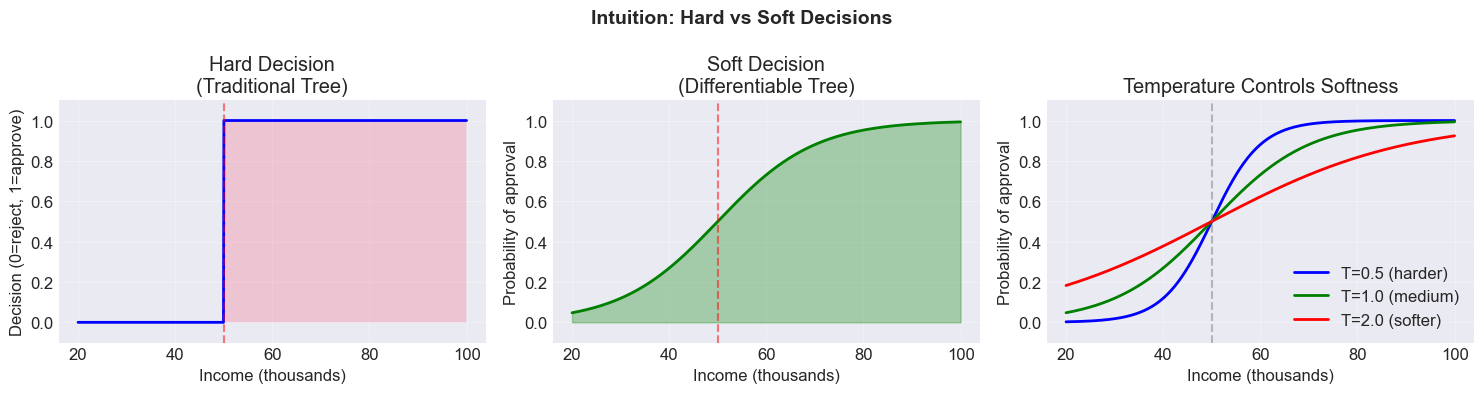

In [87]:
# Simple example: Hard vs Soft decision on a single feature
# (using numpy and matplotlib imported above)

# Generate sample incomes
incomes = np.linspace(20000, 100000, 1000)
threshold = 50000

# Hard decision function
def hard_decision(income, threshold):
    return 1.0 if income > threshold else 0.0

# Soft decision function  
def soft_decision(income, threshold, temperature=1.0):
    # Using sigmoid: smooth transition around threshold
    return 1 / (1 + np.exp(-(income - threshold) / (temperature * 10000)))

# Calculate decisions
hard_decisions = [hard_decision(inc, threshold) for inc in incomes]
soft_decisions_T1 = [soft_decision(inc, threshold, 1.0) for inc in incomes]
soft_decisions_T05 = [soft_decision(inc, threshold, 0.5) for inc in incomes]
soft_decisions_T2 = [soft_decision(inc, threshold, 2.0) for inc in incomes]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Hard Decision
ax = axes[0]
ax.plot(incomes/1000, hard_decisions, 'b-', linewidth=2)
ax.fill_between(incomes/1000, 0, hard_decisions, alpha=0.3)
ax.axvline(x=threshold/1000, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Income (thousands)')
ax.set_ylabel('Decision (0=reject, 1=approve)')
ax.set_title('Hard Decision\n(Traditional Tree)')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.1, 1.1)

# Plot 2: Soft Decision
ax = axes[1]
ax.plot(incomes/1000, soft_decisions_T1, 'g-', linewidth=2)
ax.fill_between(incomes/1000, 0, soft_decisions_T1, alpha=0.3, color='green')
ax.axvline(x=threshold/1000, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Income (thousands)')
ax.set_ylabel('Probability of approval')
ax.set_title('Soft Decision\n(Differentiable Tree)')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.1, 1.1)

# Plot 3: Temperature Effect
ax = axes[2]
ax.plot(incomes/1000, soft_decisions_T05, 'b-', label='T=0.5 (harder)', linewidth=2)
ax.plot(incomes/1000, soft_decisions_T1, 'g-', label='T=1.0 (medium)', linewidth=2)
ax.plot(incomes/1000, soft_decisions_T2, 'r-', label='T=2.0 (softer)', linewidth=2)
ax.axvline(x=threshold/1000, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Income (thousands)')
ax.set_ylabel('Probability of approval')
ax.set_title('Temperature Controls Softness')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.1, 1.1)

plt.suptitle('Intuition: Hard vs Soft Decisions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Key Observations:**
1. Hard decision: Instant jump from 0 to 1 at threshold (not differentiable)
2. Soft decision: Smooth transition allows gradients to flow
3. Temperature controls the 'sharpness' of the transition

#### Why This Matters: The Gradient Problem


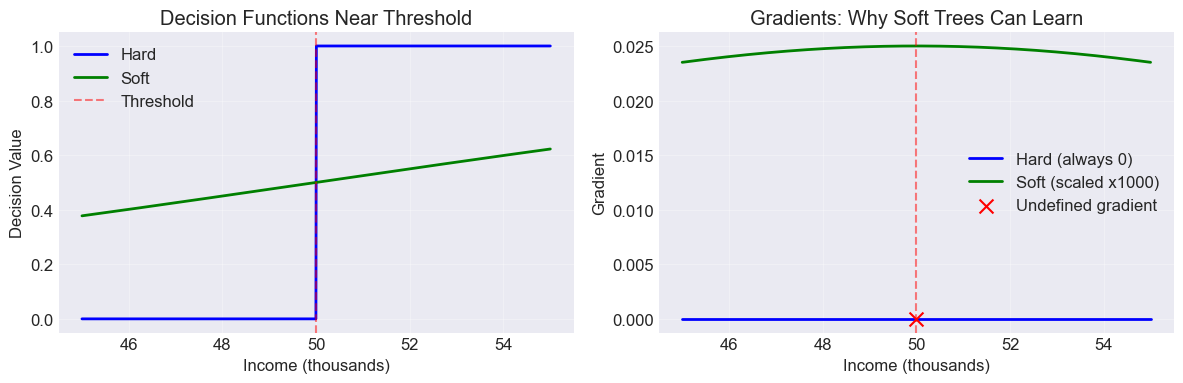

In [88]:
# Demonstrate the gradient problem
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Calculate derivatives (gradients)
income_range = np.linspace(45000, 55000, 1000)

# For hard decision - gradient is undefined at threshold, 0 everywhere else
hard_gradients = np.zeros_like(income_range)
# Mark undefined point
threshold_idx = np.argmin(np.abs(income_range - threshold))

# For soft decision - smooth gradients everywhere
soft_values = [soft_decision(inc, threshold, 1.0) for inc in income_range]
soft_gradients = np.gradient(soft_values, income_range)

# Plot 1: Decision functions around threshold
ax = axes[0]
hard_vals = [hard_decision(inc, threshold) for inc in income_range]
ax.plot(income_range/1000, hard_vals, 'b-', label='Hard', linewidth=2)
ax.plot(income_range/1000, soft_values, 'g-', label='Soft', linewidth=2)
ax.axvline(x=threshold/1000, color='r', linestyle='--', alpha=0.5, label='Threshold')
ax.set_xlabel('Income (thousands)')
ax.set_ylabel('Decision Value')
ax.set_title('Decision Functions Near Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Gradients
ax = axes[1]
ax.plot(income_range/1000, hard_gradients, 'b-', label='Hard (always 0)', linewidth=2)
ax.plot(income_range/1000, soft_gradients * 1000, 'g-', label='Soft (scaled x1000)', linewidth=2)
ax.axvline(x=threshold/1000, color='r', linestyle='--', alpha=0.5)
ax.scatter([threshold/1000], [0], color='red', s=100, marker='x', 
          label='Undefined gradient', zorder=5)
ax.set_xlabel('Income (thousands)')
ax.set_ylabel('Gradient')
ax.set_title('Gradients: Why Soft Trees Can Learn')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Why Soft Trees Enable Learning:**
- Hard trees: Gradient is 0 almost everywhere (no learning signal)
- Soft trees: Smooth gradients provide direction for optimization
- This allows backpropagation to work through the tree structure

### The Innovation: Soft Routing

Instead of hard binary decisions, soft decision trees use probabilistic routing. For a node with parameters $\mathbf{w}$ and bias $b$, the routing probability is:

$$p_{right} = \sigma\left(\frac{\mathbf{w}^T \mathbf{x} + b}{T}\right)$$

where $\sigma$ is the sigmoid function and $T$ is a temperature parameter.

The probability of reaching a leaf $\ell$ is the product of routing probabilities along the path:

$$p(\ell|\mathbf{x}) = \prod_{n \in path(\ell)} p_n(\mathbf{x})$$

This formulation enables gradient flow through the entire tree structure.

### Implementing a Soft Decision Tree

In [89]:
class SoftDecisionTree(nn.Module):
    """
    A differentiable decision tree using soft routing.
    Each internal node learns a linear decision boundary.
    """
    def __init__(self, input_dim, depth=3, num_classes=2, temperature_init=1.0):
        super().__init__()
        self.input_dim = input_dim
        self.depth = depth
        self.num_classes = num_classes
        self.num_leaves = 2 ** depth
        # Store the scaler for later use
        self.scaler = None
        # Internal nodes learn routing decisions (one linear per node at each level)
        self.decision_layers = nn.ModuleList()
        for d in range(depth):
            n_nodes = 2 ** d
            layer = nn.Linear(input_dim, n_nodes)
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            self.decision_layers.append(layer)
        # Leaf logits (class scores per leaf)
        self.leaf_logits = nn.Parameter(torch.randn(self.num_leaves, num_classes))
        # Learnable temperature (in log space)
        self.log_temperature = nn.Parameter(torch.log(torch.tensor(temperature_init)))

    def forward(self, x):
        batch_size = x.shape[0]
        # Probability of reaching each node at current level (start at root)
        path_prob = torch.ones(batch_size, 1, device=x.device)
        for d in range(self.depth):
            n_current_nodes = 2 ** d
            decisions = self.decision_layers[d](x)  # [batch_size, n_current_nodes]
            temperature = torch.exp(self.log_temperature)
            routing_probs = torch.sigmoid(decisions / temperature)
            new_path_prob = []
            for node_idx in range(n_current_nodes):
                parent_prob = path_prob[:, node_idx:node_idx+1]
                node_routing = routing_probs[:, node_idx:node_idx+1]
                left_prob = parent_prob * (1 - node_routing)
                right_prob = parent_prob * node_routing
                new_path_prob.extend([left_prob, right_prob])
            path_prob = torch.cat(new_path_prob, dim=1)
        # Leaf probabilities and final output
        leaf_probs = F.softmax(self.leaf_logits, dim=1)
        output = torch.matmul(path_prob, leaf_probs)
        return torch.log(output + 1e-10), path_prob

    def get_temperature(self):
        return torch.exp(self.log_temperature).item()

    def set_scaler(self, scaler):
        """Store the scaler used during training."""
        self.scaler = scaler

**Key Design Choices**:
1. **Temperature Control**: Lower temperature → harder decisions (more tree-like)
2. **Learnable Routing**: Each node learns its own splitting hyperplane
3. **Probabilistic Paths**: Samples can partially flow through multiple paths
4. **End-to-end Training**: All parameters optimize jointly via backpropagation
5. **Scaler Storage**: Properly stores the scaler for consistent preprocessing


### Training the Soft Decision Tree

Now let's train our soft tree on the credit data and compare it with traditional trees.


Training Soft Decision Tree...
Epoch   0 | Train Loss: 0.6069 | Val Loss: 0.6006 | Temp: 0.429
Epoch  50 | Train Loss: 0.5988 | Val Loss: 0.5973 | Temp: 0.322
Early stopping at epoch 93


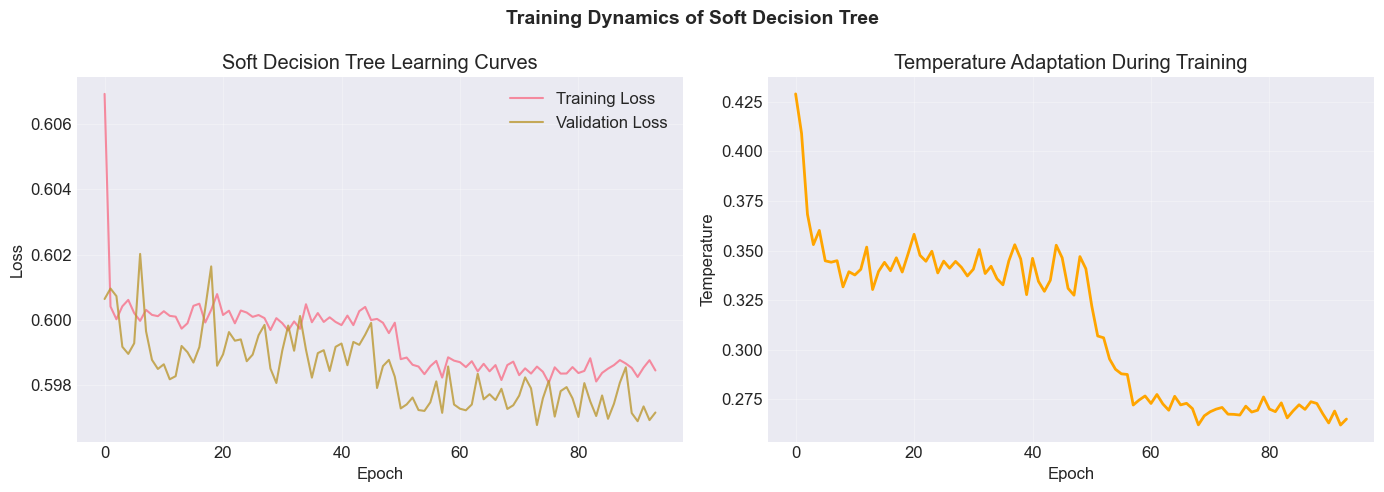


EVALUATION ON DIFFERENT DATA DISTRIBUTIONS
Imbalanced Test Set (8% positive class):
  Hard Tree AUC: 0.662
  Soft Tree AUC: 0.744

Balanced Test Set (50% positive class):
  Hard Tree AUC: 0.655
  Soft Tree AUC: 0.726


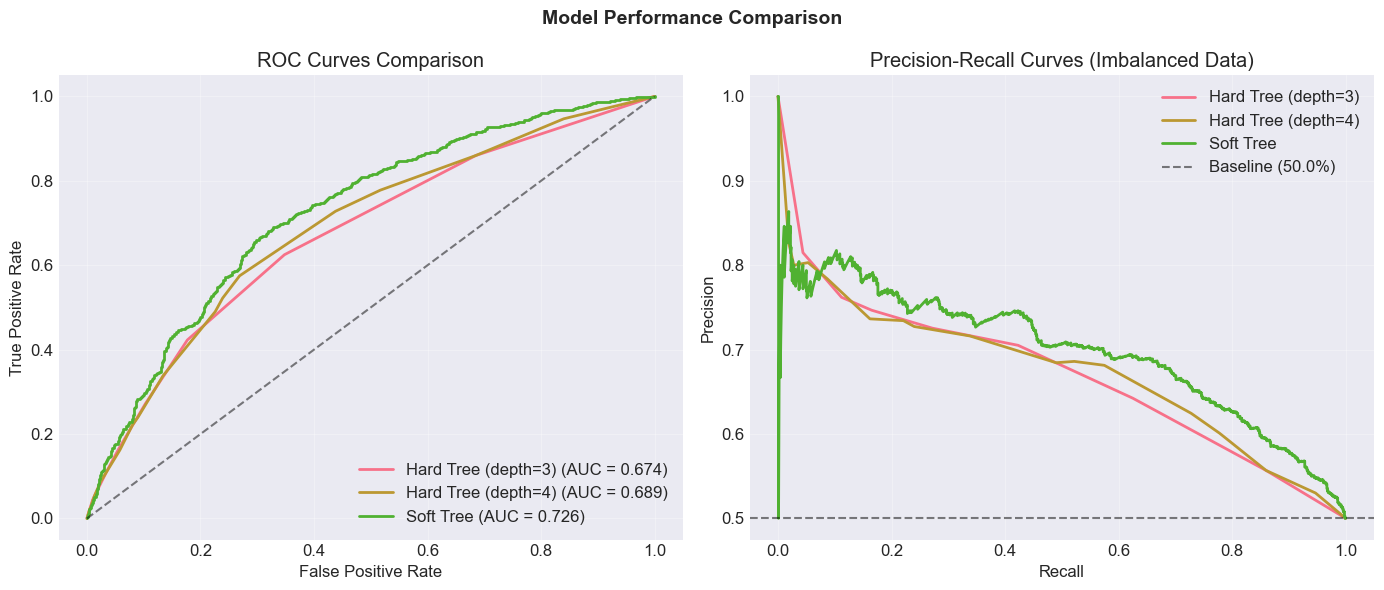

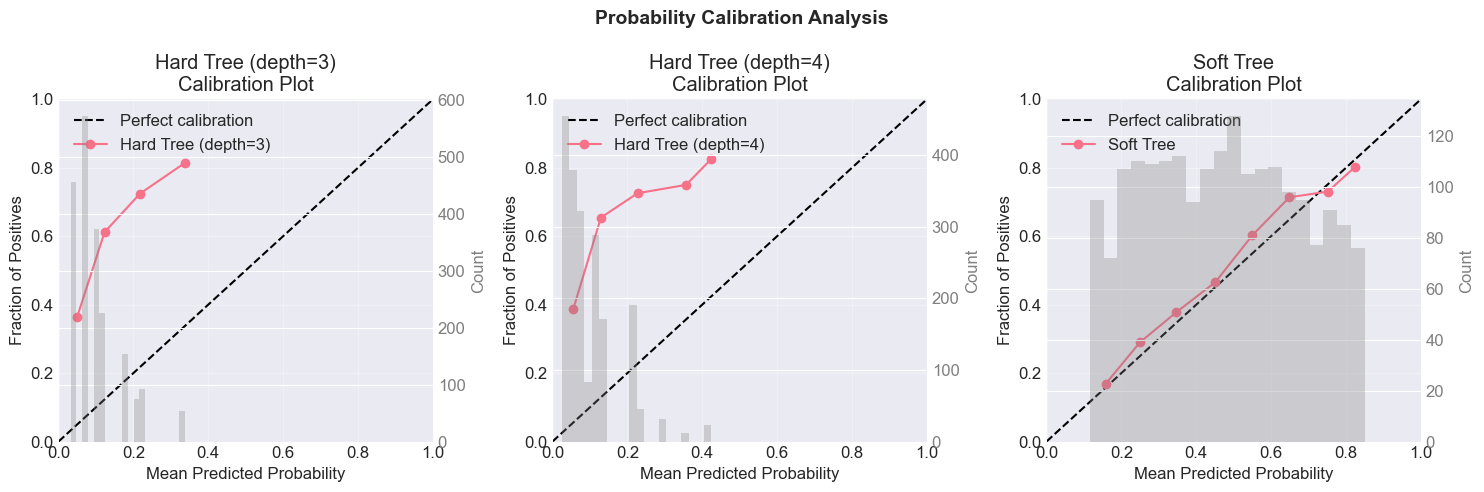

In [90]:
# Prepare data for PyTorch
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler!

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

# Create data loaders
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

"""
Training the Soft Decision Tree with improved hyperparameters, validation, and early stopping
"""
# Initialize soft decision tree (lower initial temperature)
soft_tree = SoftDecisionTree(
    input_dim=X_train.shape[1],
    depth=4,
    num_classes=2,
    temperature_init=0.5
)

# Store the scaler in the model
soft_tree.set_scaler(scaler)

# Optimizer and loss (more aggressive LR, lighter weight decay)
optimizer = torch.optim.Adam(soft_tree.parameters(), lr=0.005, weight_decay=0.001)
class_weights = torch.FloatTensor([1.0, 10.0])
criterion = nn.NLLLoss(weight=class_weights)

# LR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Train/validation split for monitoring
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train.values, test_size=0.2, random_state=42, stratify=y_train
)
X_train_split_tensor = torch.FloatTensor(X_train_split)
y_train_split_tensor = torch.LongTensor(y_train_split)
X_val_tensor = torch.FloatTensor(X_val_split)
y_val_tensor = torch.LongTensor(y_val_split)

# Training with validation and early stopping
print("Training Soft Decision Tree...")
soft_tree.train()
train_losses = []
val_losses = []
temperatures = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(300):
    # Training
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        log_probs, _ = soft_tree(batch_x)
        loss = criterion(log_probs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(soft_tree.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation
    with torch.no_grad():
        val_log_probs, _ = soft_tree(X_val_tensor)
        val_loss = criterion(val_log_probs, y_val_tensor).item()
        val_losses.append(val_loss)
    
    avg_loss = epoch_loss / max(len(train_loader), 1)
    train_losses.append(avg_loss)
    temperatures.append(soft_tree.get_temperature())
    scheduler.step()
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = soft_tree.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= 20:
            print(f"Early stopping at epoch {epoch}")
            soft_tree.load_state_dict(best_state)
            break
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f} | Temp: {soft_tree.get_temperature():.3f}")

# Evaluation on test set
soft_tree.eval()
with torch.no_grad():
    log_probs_test, _ = soft_tree(X_test_tensor)
    soft_probs = torch.exp(log_probs_test)[:, 1].numpy()

# Visualize learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(train_losses, label='Training Loss', alpha=0.8)
ax1.plot(val_losses, label='Validation Loss', alpha=0.8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Soft Decision Tree Learning Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(temperatures, color='orange', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature Adaptation During Training')
ax2.grid(True, alpha=0.3)

plt.suptitle('Training Dynamics of Soft Decision Tree', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Evaluate on both balanced and imbalanced test sets
print("\n" + "="*60)
print("EVALUATION ON DIFFERENT DATA DISTRIBUTIONS")
print("="*60)

# Imbalanced (real-world) evaluation
with torch.no_grad():
    log_probs_imb, _ = soft_tree(X_test_tensor)
    soft_probs_imb = torch.exp(log_probs_imb)[:, 1].numpy()

print(f"Imbalanced Test Set (8% positive class):")
print(f"  Hard Tree AUC: {roc_auc_score(y_test, simple_tree.predict_proba(X_test)[:, 1]):.3f}")
print(f"  Soft Tree AUC: {roc_auc_score(y_test, soft_probs_imb):.3f}")

# Balanced evaluation
X_test_bal_scaled = scaler.transform(X_test_balanced)
X_test_bal_tensor = torch.FloatTensor(X_test_bal_scaled)
with torch.no_grad():
    log_probs_bal, _ = soft_tree(X_test_bal_tensor)
    soft_probs_balanced = torch.exp(log_probs_bal)[:, 1].numpy()
    
print(f"\nBalanced Test Set (50% positive class):")
print(f"  Hard Tree AUC: {roc_auc_score(y_test_balanced, simple_tree.predict_proba(X_test_balanced)[:, 1]):.3f}")
print(f"  Soft Tree AUC: {roc_auc_score(y_test_balanced, soft_probs_balanced):.3f}")

# Helper: ROC/PR comparison
from sklearn.metrics import roc_curve, auc
def plot_roc_comparison(models_dict, X_test, y_test):
    """Plot ROC and PR curves for provided probability outputs."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    # ROC Curves
    for name, probs in models_dict.items():
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves Comparison')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    # Precision-Recall Curves
    from sklearn.metrics import precision_recall_curve
    for name, probs in models_dict.items():
        precision, recall, _ = precision_recall_curve(y_test, probs)
        ax2.plot(recall, precision, linewidth=2, label=name)
    baseline = float(np.mean(y_test))
    ax2.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label=f'Baseline ({baseline:.1%})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves (Imbalanced Data)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Helper: Calibration curves
def plot_calibration_curves(models_dict, y_test):
    """Plot calibration curves to assess probability quality."""
    fig, axes = plt.subplots(1, len(models_dict), figsize=(5*len(models_dict), 5))
    if len(models_dict) == 1:
        axes = [axes]
    for ax, (name, probs) in zip(axes, models_dict.items()):
        fraction_pos, mean_pred = calibration_curve(y_test, probs, n_bins=10)
        ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
        ax.plot(mean_pred, fraction_pos, 'o-', label=name, markersize=6)
        ax2 = ax.twinx()
        ax2.hist(probs, bins=20, alpha=0.3, color='gray', edgecolor='none')
        ax2.set_ylabel('Count', color='gray')
        ax2.tick_params(axis='y', labelcolor='gray')
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title(f'{name}\nCalibration Plot')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
    plt.suptitle('Probability Calibration Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Collect predictions on balanced test set
hard_tree_d3 = DecisionTreeClassifier(max_depth=3, random_state=42)
hard_tree_d3.fit(X_train, y_train)
hard_probs_d3_bal = hard_tree_d3.predict_proba(X_test_balanced)[:, 1]

hard_tree_d4 = DecisionTreeClassifier(max_depth=4, random_state=42)
hard_tree_d4.fit(X_train, y_train)
hard_probs_d4_bal = hard_tree_d4.predict_proba(X_test_balanced)[:, 1]

with torch.no_grad():
    X_test_bal_scaled = torch.FloatTensor(scaler.transform(X_test_balanced))
    soft_logp_bal, _ = soft_tree(X_test_bal_scaled)
    soft_probs_balanced = torch.exp(soft_logp_bal)[:, 1].numpy()

models_dict = {
    'Hard Tree (depth=3)': hard_probs_d3_bal,
    'Hard Tree (depth=4)': hard_probs_d4_bal,
    'Soft Tree': soft_probs_balanced
}

plot_roc_comparison(models_dict, X_test_balanced, y_test_balanced)
plot_calibration_curves(models_dict, y_test_balanced)

**Key Insights**:
- The temperature parameter adapts during training
- Soft trees often achieve comparable or better performance
- Training is smooth and stable due to differentiability

## Visualizing Soft vs Hard Decision Boundaries

The most striking difference between hard and soft trees is in their decision boundaries. Let's visualize this difference.


Creating 2D visualization with features: ['EXT_SOURCE_3', 'EXT_SOURCE_2']


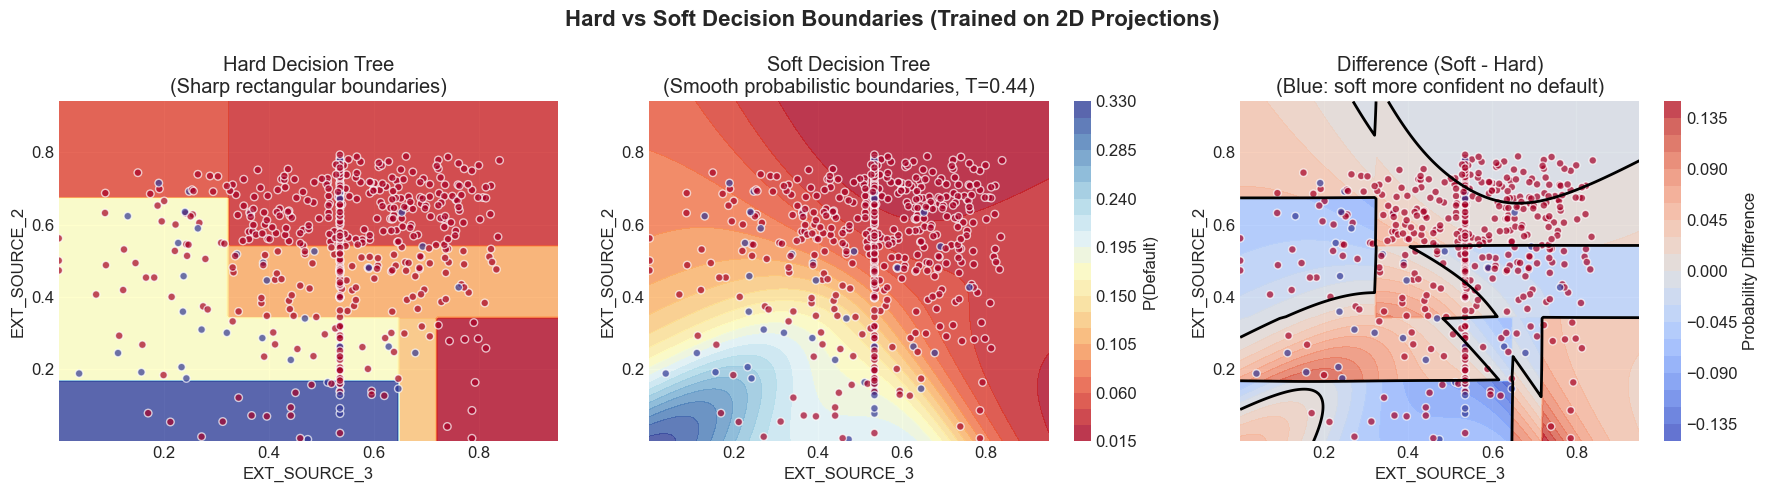

In [91]:
def compare_decision_boundaries_2d(X, y, feature_indices):
    """
    Compare hard and soft tree decision boundaries on 2D data.
    This trains NEW 2D models for visualization purposes.
    """
    # Prepare 2D data
    feature_names = X.columns[feature_indices]
    X_2d = X.iloc[:, feature_indices].values
    
    # Create separate scaler for 2D data
    scaler_2d = StandardScaler()
    X_2d_scaled = scaler_2d.fit_transform(X_2d)
    
    # Train hard tree on 2D data
    hard_tree_2d = DecisionTreeClassifier(max_depth=3, random_state=42)
    hard_tree_2d.fit(X_2d, y)
    
    # Train soft tree on 2D data
    X_2d_tensor = torch.FloatTensor(X_2d_scaled)
    y_2d_tensor = torch.LongTensor(y.values)
    
    soft_tree_2d = SoftDecisionTree(input_dim=2, depth=3, num_classes=2)
    soft_tree_2d.set_scaler(scaler_2d)
    optimizer_2d = torch.optim.Adam(soft_tree_2d.parameters(), lr=0.01)
    criterion_2d = nn.NLLLoss()
    
    # Quick training
    soft_tree_2d.train()
    for epoch in range(200):
        log_probs, _ = soft_tree_2d(X_2d_tensor)
        loss = criterion_2d(log_probs, y_2d_tensor)
        optimizer_2d.zero_grad()
        loss.backward()
        optimizer_2d.step()
    soft_tree_2d.eval()
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Setup mesh
    margin = 0.1
    x_min, x_max = X_2d[:, 0].min() * (1-margin), X_2d[:, 0].max() * (1+margin)
    y_min, y_max = X_2d[:, 1].min() * (1-margin), X_2d[:, 1].max() * (1+margin)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Hard tree predictions
    Z_hard = hard_tree_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_hard = Z_hard.reshape(xx.shape)
    
    # Soft tree predictions - use the 2D scaler!
    mesh_scaled = scaler_2d.transform(np.c_[xx.ravel(), yy.ravel()])
    mesh_tensor = torch.FloatTensor(mesh_scaled)
    with torch.no_grad():
        log_probs_mesh, _ = soft_tree_2d(mesh_tensor)
        Z_soft = torch.exp(log_probs_mesh)[:, 1].numpy()
    Z_soft = Z_soft.reshape(xx.shape)
    
    # Subsample for visualization clarity
    sample_size = min(500, len(X_2d))
    indices = np.random.choice(len(X_2d), sample_size, replace=False)
    
    # Plot hard tree
    im1 = axes[0].contourf(xx, yy, Z_hard, levels=20, cmap='RdYlBu', alpha=0.8)
    axes[0].contour(xx, yy, Z_hard, levels=[0.5], colors='black', linewidths=2)
    axes[0].scatter(X_2d[indices, 0], X_2d[indices, 1], c=y.iloc[indices], 
                   cmap='RdYlBu', edgecolor='white', s=30, alpha=0.7)
    axes[0].set_title('Hard Decision Tree\n(Sharp rectangular boundaries)')
    axes[0].set_xlabel(feature_names[0])
    axes[0].set_ylabel(feature_names[1])
    
    # Plot soft tree
    im2 = axes[1].contourf(xx, yy, Z_soft, levels=20, cmap='RdYlBu', alpha=0.8)
    axes[1].contour(xx, yy, Z_soft, levels=[0.5], colors='black', linewidths=2)
    axes[1].scatter(X_2d[indices, 0], X_2d[indices, 1], c=y.iloc[indices],
                   cmap='RdYlBu', edgecolor='white', s=30, alpha=0.7)
    axes[1].set_title(f'Soft Decision Tree\n(Smooth probabilistic boundaries, T={soft_tree_2d.get_temperature():.2f})')
    axes[1].set_xlabel(feature_names[0])
    axes[1].set_ylabel(feature_names[1])
    plt.colorbar(im2, ax=axes[1], label='P(Default)')
    
    # Plot difference
    diff = Z_soft - Z_hard
    im3 = axes[2].contourf(xx, yy, diff, levels=20, cmap='coolwarm', alpha=0.8)
    axes[2].contour(xx, yy, diff, levels=[0], colors='black', linewidths=2)
    axes[2].scatter(X_2d[indices, 0], X_2d[indices, 1], c=y.iloc[indices],
                   cmap='RdYlBu', edgecolor='white', s=30, alpha=0.7)
    axes[2].set_title('Difference (Soft - Hard)\n(Blue: soft more confident no default)')
    axes[2].set_xlabel(feature_names[0])
    axes[2].set_ylabel(feature_names[1])
    plt.colorbar(im3, ax=axes[2], label='Probability Difference')
    
    plt.suptitle('Hard vs Soft Decision Boundaries (Trained on 2D Projections)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Use top 2 features for visualization
print(f"Creating 2D visualization with features: {top_features}")
compare_decision_boundaries_2d(X_train.head(2000), y_train.head(2000), feature_indices)

**Critical Observations**:
1. **Hard trees**: Create sharp, axis-aligned rectangular regions
2. **Soft trees**: Produce smooth, probabilistic transitions
3. **Uncertainty representation**: Soft trees naturally model prediction uncertainty

## Temperature Analysis: The Key Hyperparameter

The temperature parameter $T$ controls the "softness" of decisions. Let's analyze its effect systematically.


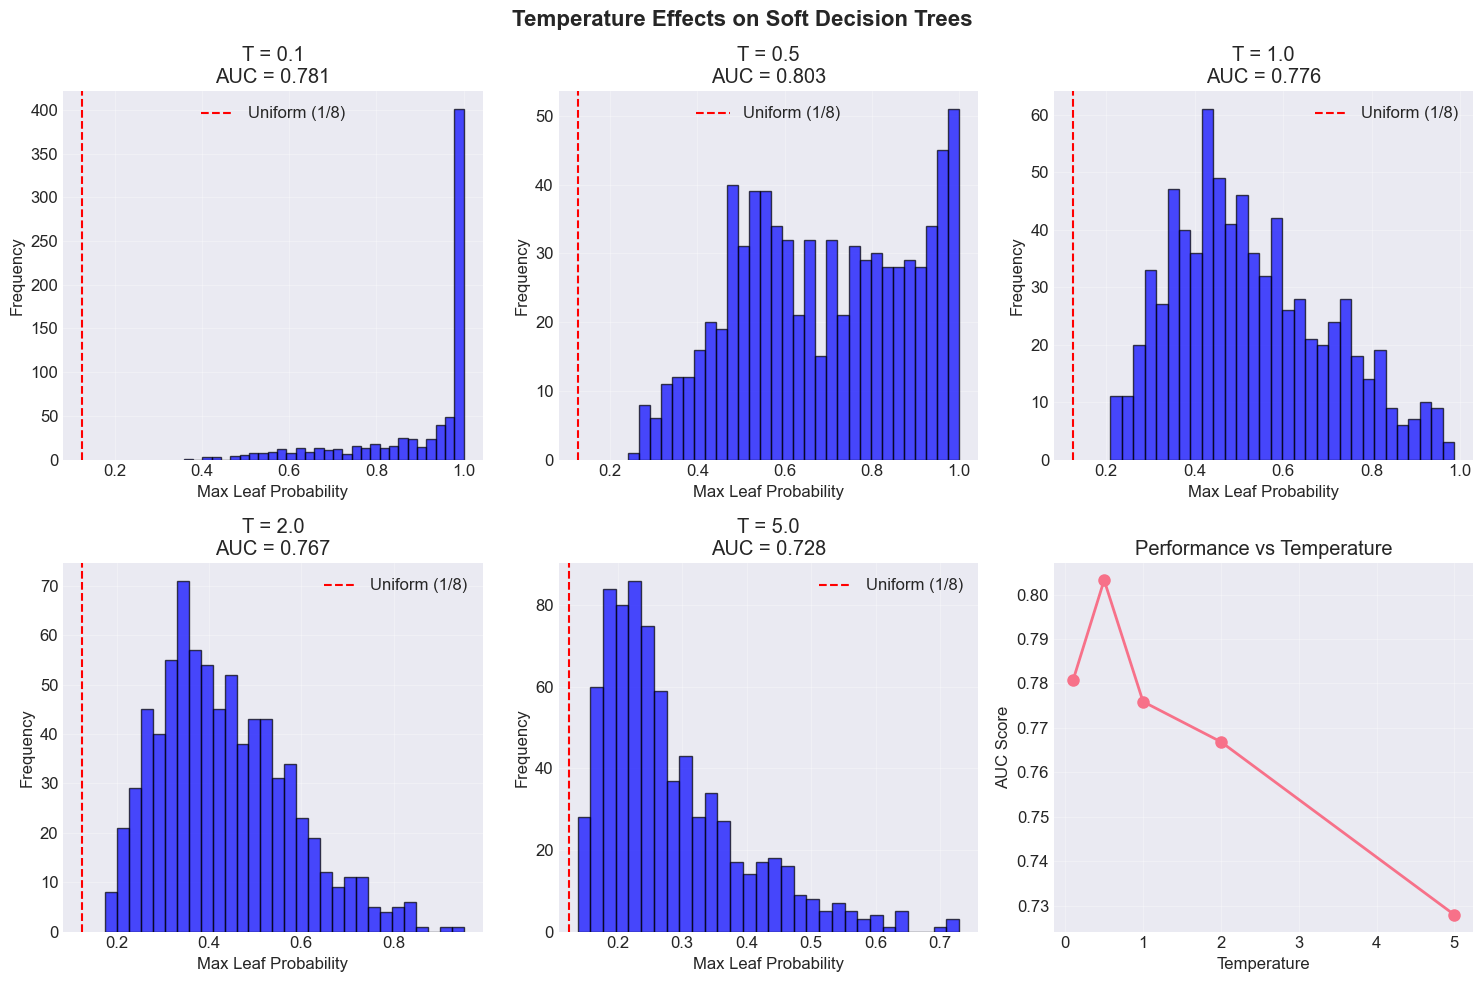


Temperature Analysis Results:
   Temperature       AUC  Path Entropy
0          0.1  0.780696      0.246202
1          0.5  0.803244      0.814673
2          1.0  0.775915      1.270639
3          2.0  0.766881      1.564346
4          5.0  0.727974      1.913124


In [92]:
def analyze_temperature_effects(X, y, temperatures=[0.1, 0.5, 1.0, 2.0, 5.0]):
    """
    Analyze how temperature affects soft tree behavior using a balanced subset.
    """
    # Use balanced subset for fair comparison
    X_bal, y_bal = create_balanced_subset(X, y, 1000)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_bal)
    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.LongTensor(y_bal.values)
    
    results = []
    path_entropies = []
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, temp in enumerate(temperatures):
        # Train soft tree with fixed temperature
        soft_tree_temp = SoftDecisionTree(
            input_dim=X.shape[1],
            depth=3,
            num_classes=2,
            temperature_init=temp
        )
        soft_tree_temp.set_scaler(scaler)
        
        # Freeze temperature parameter
        soft_tree_temp.log_temperature.requires_grad = False
        
        optimizer = torch.optim.Adam(
            [p for p in soft_tree_temp.parameters() if p.requires_grad],
            lr=0.01
        )
        
        # Calculate class weights on the balanced subset used for training/evaluation
        class_counts = np.bincount(y_bal.values)
        if len(class_counts) == 2 and class_counts.min() > 0:
            weight_for_0 = len(y_bal) / (2.0 * class_counts[0])
            weight_for_1 = len(y_bal) / (2.0 * class_counts[1])
            class_weights = torch.FloatTensor([weight_for_0, weight_for_1])
        else:
            class_weights = None
            
        criterion = nn.NLLLoss(weight=class_weights) if class_weights is not None else nn.NLLLoss()
        
        # Train
        soft_tree_temp.train()
        for epoch in range(100):
            log_probs, path_probs = soft_tree_temp(X_tensor)
            loss = criterion(log_probs, y_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluate
        soft_tree_temp.eval()
        with torch.no_grad():
            log_probs, path_probs = soft_tree_temp(X_tensor)
            
            # Calculate path entropy (measure of "softness")
            # Avoid log(0) by adding small epsilon
            path_entropy = -(path_probs * torch.log(path_probs + 1e-10)).sum(dim=1).mean()
            path_entropies.append(path_entropy.item())
            
            # Get predictions
            probs = torch.exp(log_probs)[:, 1].numpy()
            preds = (probs > 0.5).astype(int)
            # Evaluate against the same balanced subset labels to avoid length mismatch
            auc = roc_auc_score(y_bal, probs)
            
            results.append({
                'Temperature': temp,
                'AUC': auc,
                'Path Entropy': path_entropy.item()
            })
        
        # Visualize path probability distribution
        ax = axes[idx]
        path_probs_np = path_probs.numpy()
        
        # Show distribution of max path probability (how "hard" decisions are)
        max_probs = path_probs_np.max(axis=1)
        ax.hist(max_probs, bins=30, alpha=0.7, color='blue', edgecolor='black')
        ax.set_xlabel('Max Leaf Probability')
        ax.set_ylabel('Frequency')
        ax.set_title(f'T = {temp}\nAUC = {auc:.3f}')
        ax.axvline(x=1.0/8, color='red', linestyle='--', label='Uniform (1/8)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Summary plot
    ax = axes[-1]
    results_df = pd.DataFrame(results)
    ax.plot(results_df['Temperature'], results_df['AUC'], 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('Temperature')
    ax.set_ylabel('AUC Score')
    ax.set_title('Performance vs Temperature')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Temperature Effects on Soft Decision Trees', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results)

# Analyze temperature effects on a sample
sample_size = 5000
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[sample_indices]
y_sample = y_train.iloc[sample_indices]

temp_results = analyze_temperature_effects(X_sample, y_sample)
print("\nTemperature Analysis Results:")
print(temp_results.to_string())

**Key Temperature Insights**:
- **Low T (< 0.5)**: Nearly hard decisions, similar to traditional trees
- **Medium T (0.5-2)**: Balanced soft routing, often best performance
- **High T (> 2)**: Very soft decisions, may underfit
- **Path Entropy**: Measures decision uncertainty - higher means softer


## Conclusions and Key Takeaways

### Performance vs. Interpretability

1. Hard Decision Trees
   - Maximum interpretability; every decision is traceable
   - Minimal tuning; fast to train and explain
   - Limited by axis-aligned splits; no neural integration

2. Soft Decision Trees
   - Differentiable; trainable with gradient methods
   - Smooth decision boundaries; can plug into neural nets
   - Less interpretable; temperature requires careful tuning

### When to Use Each
- Use hard trees when interpretability is required (e.g., regulation, audits)
- Use soft trees when end-to-end differentiability or neural integration is needed
- Consider ensembles (RF/GBM) for strong baselines when interpretability is secondary

### Temperature Guidance
- Low T (< 0.5): near-hard routing
- Medium T (0.5–1.0): balanced routing; often best trade-off
- High T (> 2.0): very soft routing; risk of underfitting

### Acknowledgments

- **Dataset**: This notebook uses the Home Credit Default Risk dataset from Kaggle.
  - Source: https://www.kaggle.com/competitions/home-credit-default-risk
  - Copyright belongs to the original data owners; please review Kaggle's terms of use and the dataset license before redistribution.
- **Libraries**: scikit-learn (decision trees, metrics, visualization), PyTorch (soft tree implementation), NumPy, pandas, seaborn, matplotlib.
- **Soft Decision Trees (prior work)**:
  - Frosst, N., & Hinton, G. (2017). Distilling a Neural Network Into a Soft Decision Tree.
  - Kontschieder, P., Fiterau, M., Criminisi, A., & Bulo, S. R. (2015). Deep Neural Decision Forests. ICCV.
  - This notebook includes an educational implementation inspired by these ideas for instructional purposes.
